In [1]:
# Import all needed libraries
import pandas as pd
import matplotlib.pyplot as plt

# Load the data that we will use

We have this data about the customers:

| PatientId | AppointmentID | Gender | ScheduledDay | AppointmentDay | Age | Neighbourhood | Scholarship | Hipertension | Diabetes | Alcoholism | Handcap | SMS_received | No-show |

And we want to visualize and understand it.

## Clean the data
There is some data which is not relevant for our models, for example the PatientId and AppointmentID


In [2]:
df = pd.read_csv('data/senniorhealth_patients.csv')
df = df.drop(columns=['PatientId', 'AppointmentID'])

It must be checked that the data format is valid, this is just for exploring and visualizing the data. In the final service we will develop a pipeline to clean all this data.

In [3]:
# Check if null values

columns_with_null_values = []

for key in df.keys():
    if (
        df[key].isnull().values.any() or
        df[key].isna().values.any()
    ):
        columns_with_null_values.append(key)

if columns_with_null_values:
    for column_name in columns_with_null_values:
        print(f'Must clean column {column_name}')
    raise Exception('Data not valid')
    # TODO explore what is the best solution here, drop this values or swap them with default values
else:
    print('1st step of data cleaning complete')

1st step of data cleaning complete


The next step is to transform the data in order to be able to use it

The transformations will be as follows:
* Gender -> 1 For Female 0 For Male
* ScheduledDay -> To datetime
* AppointmentDay -> To datetime
* No-show -> To boolean & To numeric for correlation matrix

Also, the names of some variables will be updated, which are clearly wrong
* Handcap -> handicap
* Hipertension -> hypertension

And we will lowercase all columns that we will use in the models:
* Age -> age
* Scholarship -> scholarship
* Diabetes -> diabetes
* Alcoholism -> alcoholism
* SMS_received -> sms_received
* Neighbourhood -> neighbourhood

Finally, we will make sure that the numeric values have numeric types

In [4]:
df['gender_transformed'] = df['Gender'].where(df['Gender'] != 'F', 1)
df['gender_transformed'] = df['gender_transformed'].where(df['gender_transformed'] != 'M', 0)

df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'], format='%Y-%m-%dT%H:%M:%SZ')
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'], format='%Y-%m-%dT')

df['No-show'] = df['No-show'].where(df['No-show'] != 'Yes', True)
df['No-show'] = df['No-show'].where(df['No-show'] != 'No', False)
df['no_show_transformed'] = df['No-show'].where(df['No-show'] != True, 1)
df['no_show_transformed'] = df['no_show_transformed'].where(df['No-show'] != False, 0)

names_to_update_list = [
    ('handicap', 'Handcap'),
    ('hypertension', 'Hipertension'),
    ('age', 'Age'),
    ('scholarship', 'Scholarship'),
    ('diabetes', 'Diabetes'),
    ('alcoholism', 'Alcoholism'),
    ('sms_received', 'SMS_received'),
    ('neighbourhood', 'Neighbourhood'),
]
columns_to_drop = []
for name_to_update in names_to_update_list:
    final_name, original_name = name_to_update
    df[final_name] = df[original_name]
    columns_to_drop.append(original_name)
df.drop(columns=columns_to_drop)

# Make sure numeric values
df['gender_transformed'] = pd.to_numeric(df['gender_transformed'])
df['no_show_transformed'] = pd.to_numeric(df['no_show_transformed'])

## Extract more relevant data from the original data
We can obtain more relevant info from initial data that will be useful in the future for the model.
For example, we can make the hypothesis that the month, day and hour of scheduled and the month and day of appoint can
be relevant in order to our predictions.

Also, we may assume that the difference in days between the scheduled time and the appointment is relevant.

Therefore, we must check if the date_of_scheduled is higher than date_of_appointment (which is impossible), so we will
remove all these rows, and in the future pipeline we will assume that the dates have to be swapped.

### TODO extract extra info from internet (for example holiday days in Brazil)

In [5]:
df['day_of_week_of_scheduled'] = df['ScheduledDay'].dt.day_of_week
df['day_of_week_of_appointment'] = df['AppointmentDay'].dt.day_of_week

df['hour_of_scheduled'] = df['ScheduledDay'].dt.hour

df['day_of_scheduled'] = df['ScheduledDay'].dt.day
df['day_of_appointment'] = df['AppointmentDay'].dt.day

df['date_of_scheduled'] = df['ScheduledDay'].dt.date
df['date_of_appointment'] = df['AppointmentDay'].dt.date

df['month_of_scheduled'] = df['ScheduledDay'].dt.month
df['month_of_appointment'] = df['AppointmentDay'].dt.month

# Check for date_of_scheduled > date_of_appointment
df = df.drop(df[df['date_of_appointment'] < df['date_of_scheduled']].index)

df['days_between_scheduled_and_appointment'] = (df['date_of_appointment'] - df['date_of_scheduled']).dt.days

## Explore the data

In order to make some hypothesis, we must explore our data. We will visualize it and try to make correlations in order
to see them in a more clear way.

First we will visualize all the relevant columns vs the result:
* Gender VS No-show
* Scheduled day VS No-show
* Appointment day VS No-show
* Scheduled month VS No-show
* Appointment month VS No-show
* Scheduled hour VS No-show
* Scholarship VS No-show
* Hypertension VS No-show
* Diabetes VS No-show
* Alcoholism VS No-show
* Handicap VS No-show
* SMS received VS No-show
* Neighbourhoods VS No-show
* Day of scheduled VS No-show
* Day of appointment VS No-show
* Days between appointment and scheduled VS No-show

Also, we will represent the normalized data.

In [6]:
# No mapping needed
graph_data_list = [
    ('gender', ['F', 'M'], 'gender_transformed'),
    ('scholarship', ['Scholarship holder', 'Non-scholarship holder'], 'scholarship'),
    ('hypertension', ['With hypertension', 'Without hypertension'], 'hypertension'),
    ('diabetes', ['With diabetes', 'Without diabetes'], 'diabetes'),
    ('alcoholism', ['With alcoholism', 'Without alcoholism'], 'alcoholism'),
    ('handicap', ['With handicap', 'Without handicap'], 'handicap'),
    ('sms_received', ['With sms_received', 'Without sms_received'], 'sms_received'),
]

dfs_to_plot = []
normalized_dfs_to_plot = []
for graph_data in graph_data_list:
    labels_name, labels, df_key = graph_data
    dict_to_use = {
        labels_name: labels,
        'show': [
            len(df[(df[df_key] == 1) & (df['No-show'] == False)]),
            len(df[(df[df_key] == 0) & (df['No-show'] == False)]),
        ],
        'no_show': [
            len(df[(df[df_key] == 1) & (df['No-show'] == True)]),
            len(df[(df[df_key] == 0) & (df['No-show'] == True)]),
        ]
    }
    df_to_plot = pd.DataFrame.from_dict(dict_to_use)
    df_to_plot = df_to_plot.set_index(labels_name)
    dfs_to_plot.append(df_to_plot)

    normalized_dict_to_use = {
        labels_name: labels,
        'show_normalized': [
            dict_to_use['show'][i] / (dict_to_use['show'][i] + dict_to_use['no_show'][i]) for i in range(len(labels))
        ],
        'no_show_normalized': [
            dict_to_use['no_show'][i] / (dict_to_use['show'][i] + dict_to_use['no_show'][i]) for i in range(len(labels))
        ]
    }
    normalized_df_to_plot = pd.DataFrame.from_dict(normalized_dict_to_use)
    normalized_df_to_plot = normalized_df_to_plot.set_index(labels_name)
    normalized_dfs_to_plot.append(normalized_df_to_plot)

In [7]:
# Need mapping
days_of_week_transform = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday',
}
month_transform = {
    1: 'January',
    2: 'February',
    3: 'March',
    4: 'April',
    5: 'May',
    7: 'June',
    8: 'July',
    9: 'August',
    10: 'September',
    11: 'October',
    12: 'November',
    13: 'December',
}
hours_transform = {hour: hour for hour in range(24)}
mapping_graph_data_list = [
    ('day_of_week_of_scheduled', days_of_week_transform, 'day_of_week_of_scheduled'),
    ('day_of_week_of_appointment', days_of_week_transform, 'day_of_week_of_appointment'),
    ('month_of_scheduled', month_transform, 'month_of_scheduled'),
    ('month_of_appointment', month_transform, 'month_of_appointment'),
    ('hour_of_scheduled', hours_transform, 'hour_of_scheduled'),
]
for mapping_graph_data in mapping_graph_data_list:
    labels_name, mapper, df_key = mapping_graph_data
    dict_to_use = {
        labels_name: list(mapper.values()),
        'show': [
            len(
                df[
                    (df[df_key] == value) &
                    (df['No-show'] == False)
                    ]
            ) for value in mapper.keys()
        ],
        'no_show': [
            len(
                df[
                    (df[df_key] == value) &
                    (df['No-show'] == True)
                    ]
            ) for value in mapper.keys()
        ]
    }

    df_to_plot = pd.DataFrame.from_dict(dict_to_use)
    df_to_plot = df_to_plot.set_index(labels_name)
    dfs_to_plot.append(df_to_plot)

    normalized_dict_to_use = {
        labels_name: list(mapper.values()),
        'show_normalized': [
            dict_to_use['show'][i] /
            (
                dict_to_use['show'][i] + dict_to_use['no_show'][i]
            ) if dict_to_use['show'][i] + dict_to_use['no_show'][i] else 0 for i in range(len(mapper.values()))
        ],
        'no_show_normalized': [
            dict_to_use['no_show'][i] /
            (
                dict_to_use['show'][i] + dict_to_use['no_show'][i]
            ) if dict_to_use['show'][i] + dict_to_use['no_show'][i] else 0 for i in range(len(mapper.values()))
        ]
    }
    normalized_df_to_plot = pd.DataFrame.from_dict(normalized_dict_to_use)
    normalized_df_to_plot = normalized_df_to_plot.set_index(labels_name)
    normalized_dfs_to_plot.append(normalized_df_to_plot)


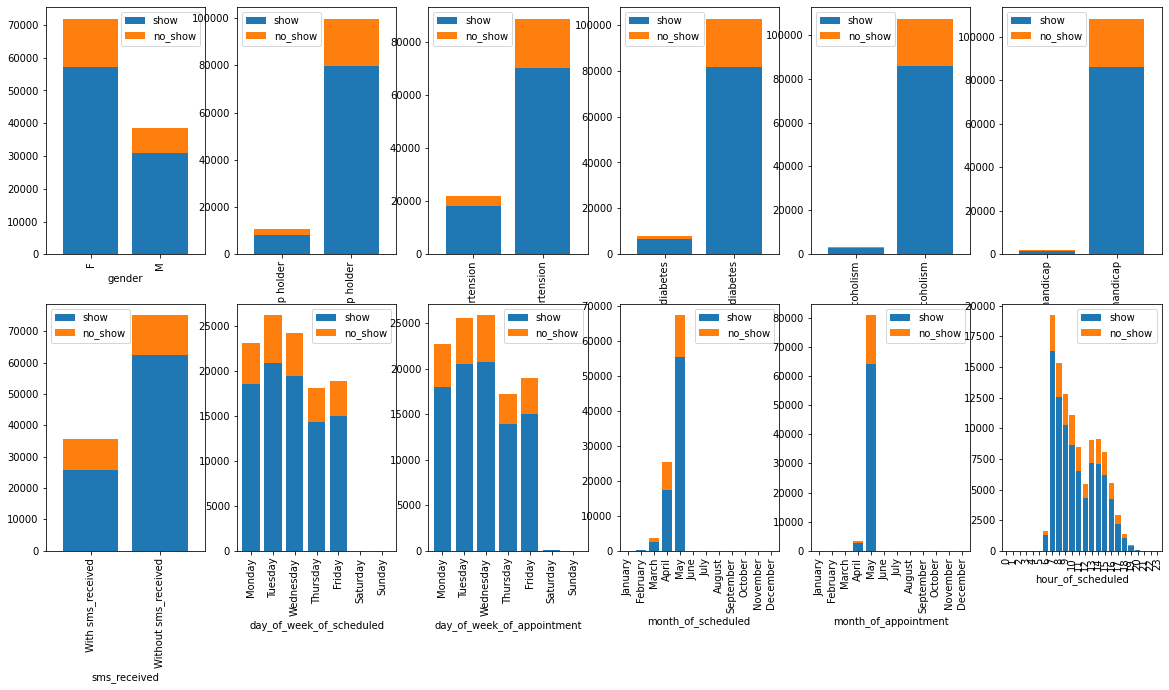

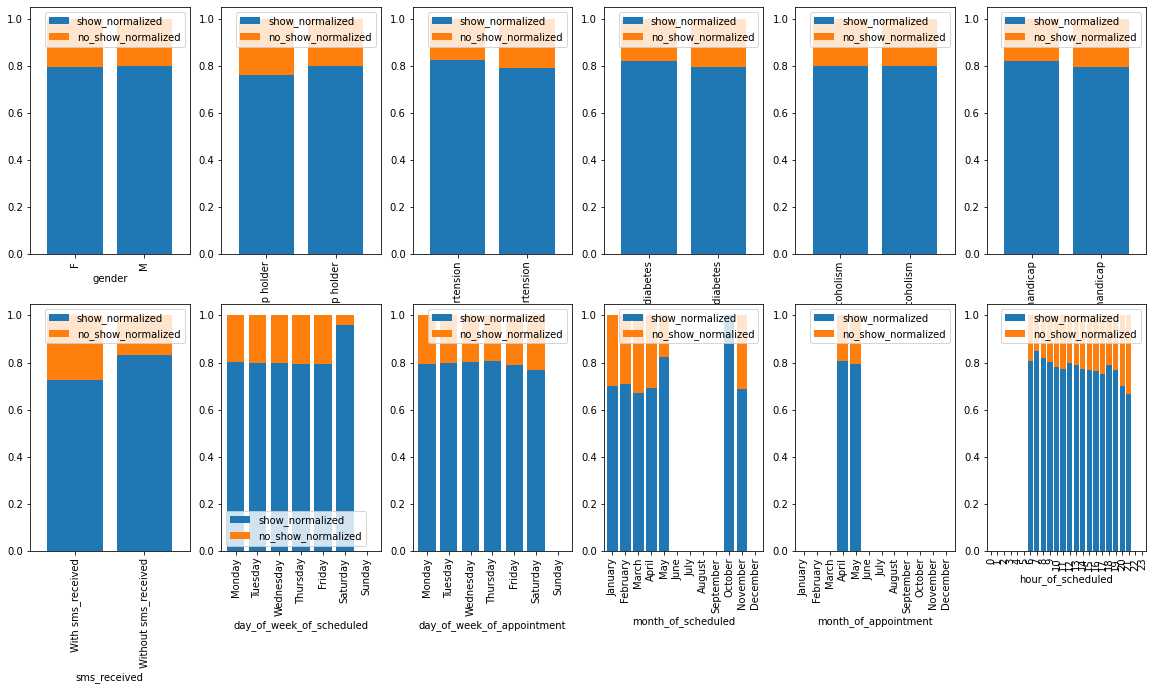

In [8]:
for list_of_dfs_to_plot in [dfs_to_plot, normalized_dfs_to_plot]:
    fig, axes = plt.subplots(nrows=2, ncols=round(len(dfs_to_plot) / 2))
    fig.set_size_inches(20, 10)
    row = 0
    col = 0
    for next_df_to_plot in list_of_dfs_to_plot:
        next_df_to_plot.plot(
            kind='bar',
            stacked='True',
            width=0.8,
            ax=axes[row, col],
        )
        col += 1
        if col == round(len(list_of_dfs_to_plot) / 2):
            col = 0
            row += 1

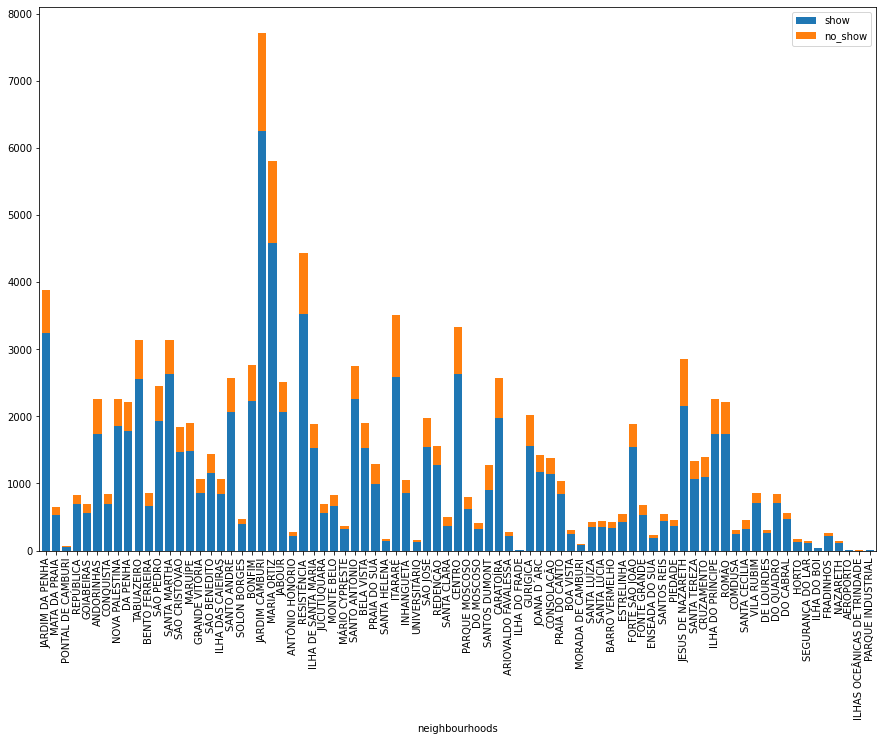

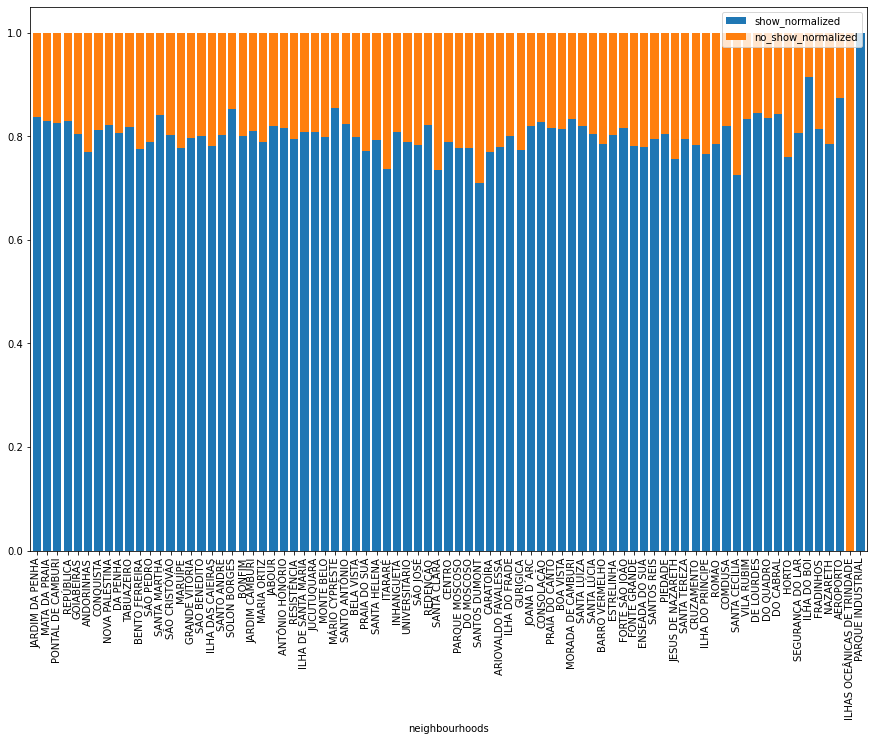

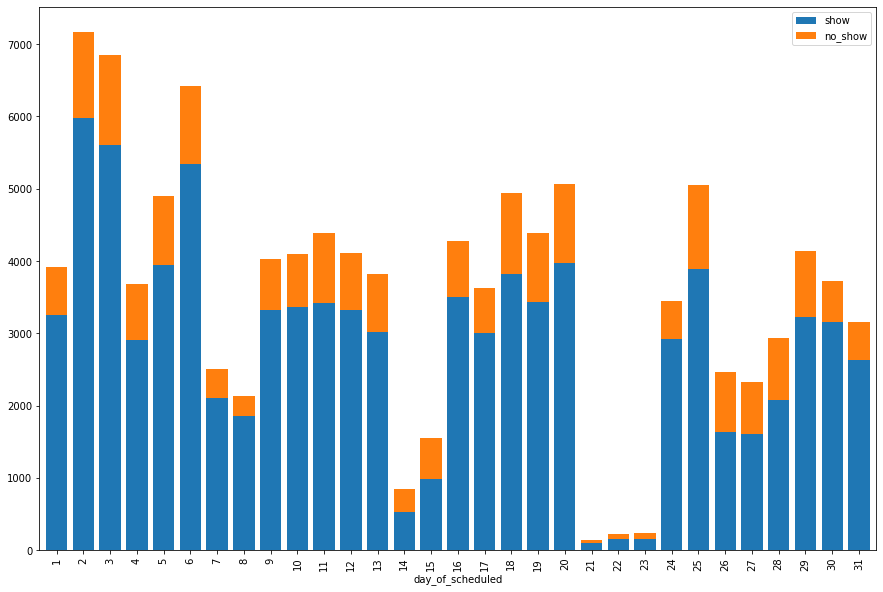

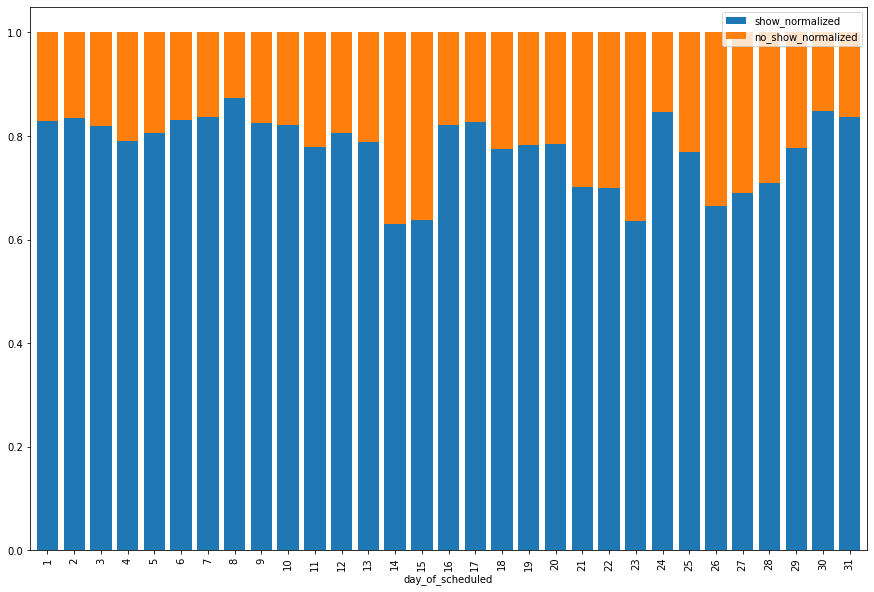

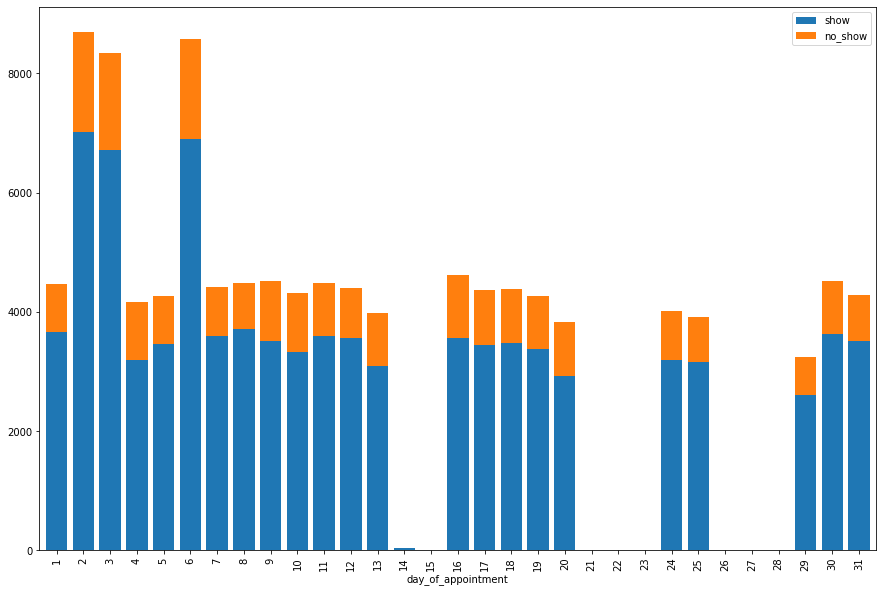

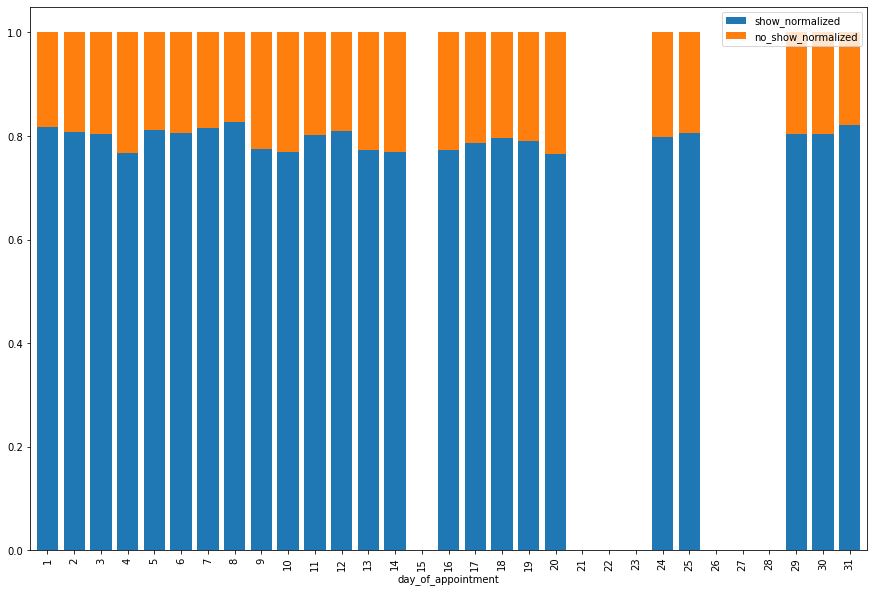

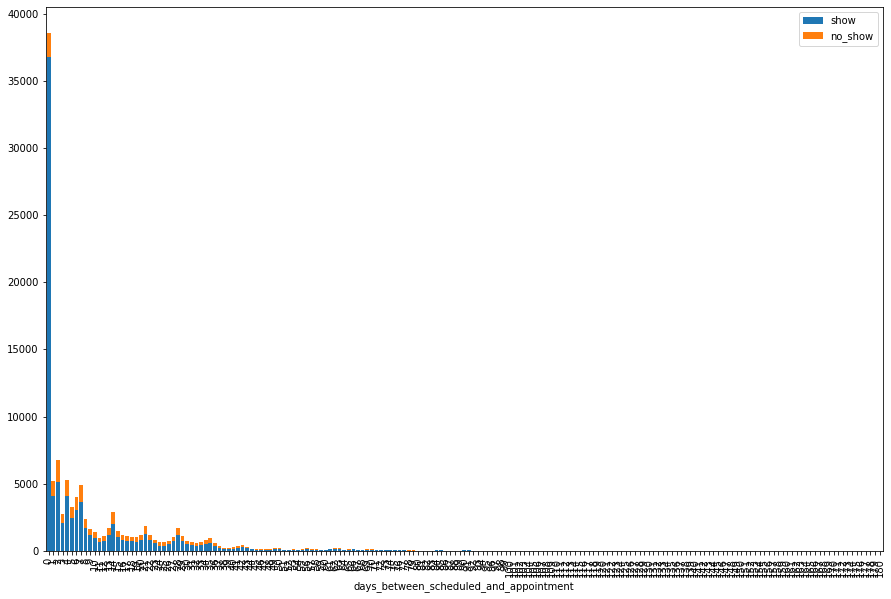

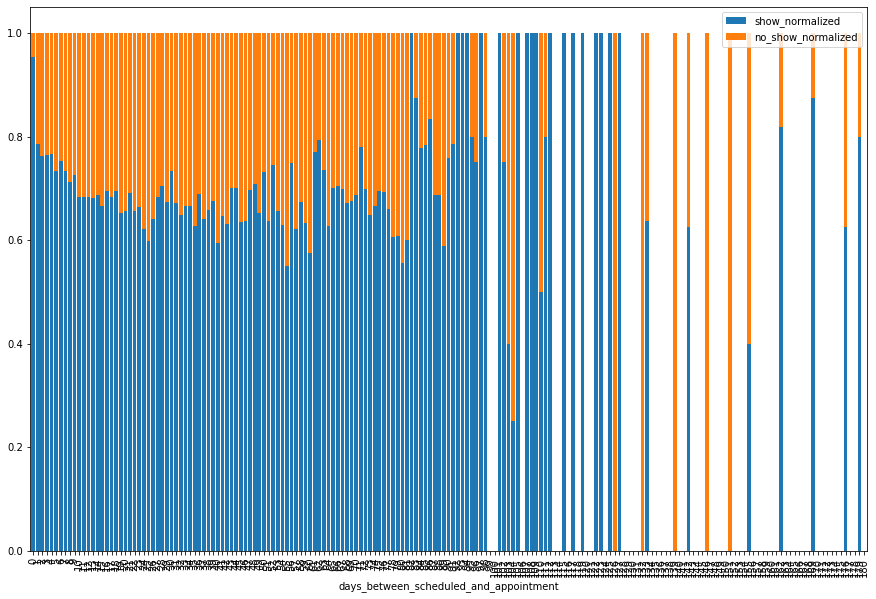

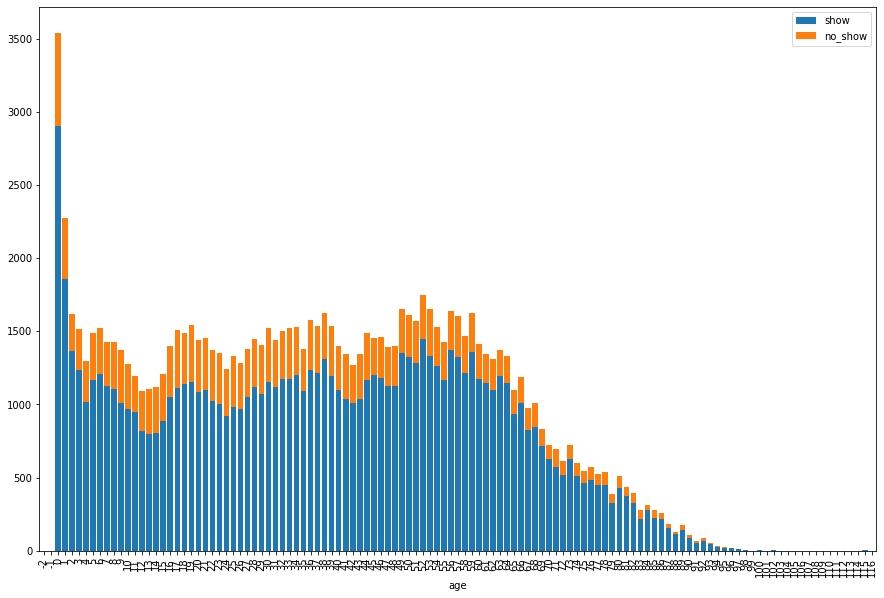

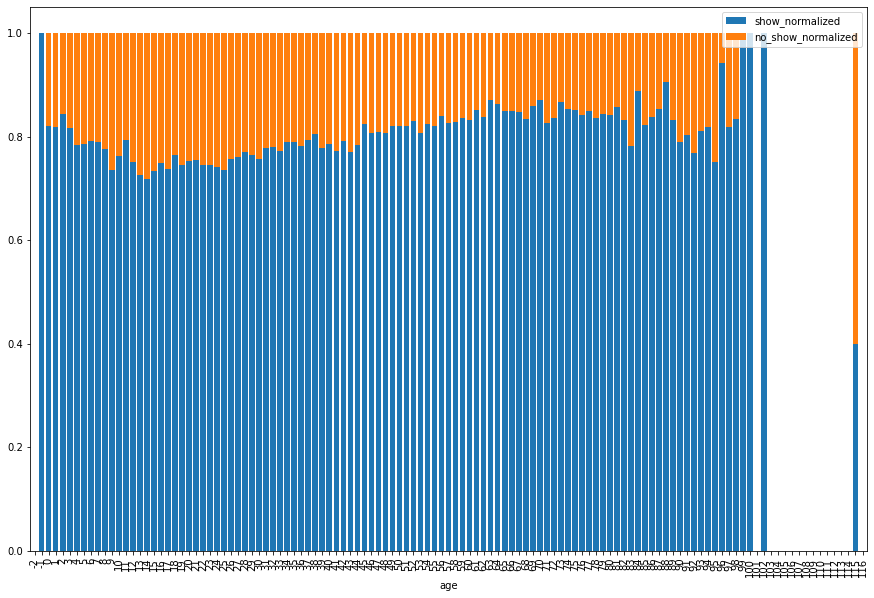

In [9]:
# Plot by not mapper but bigger plot
neighbourhoods = list(df['neighbourhood'].unique())
days_in_month = list(range(1, 32))
allow_days_between_scheduled_and_appointment = list(range(max(df['days_between_scheduled_and_appointment'] + 2)))
valid_ages = list(range(-2, max(df['age'] + 2)))  # Maybe some not yet been born?
bigger_plots_data_list = [
    ('neighbourhoods', neighbourhoods, 'neighbourhood'),
    ('day_of_scheduled', days_in_month, 'day_of_scheduled'),
    ('day_of_appointment', days_in_month, 'day_of_appointment'),
    (
        'days_between_scheduled_and_appointment',
        allow_days_between_scheduled_and_appointment,
        'days_between_scheduled_and_appointment'
    ),
    ('age', valid_ages, 'age'),
]
for bigger_plot_data in bigger_plots_data_list:
    label_name, values, df_key = bigger_plot_data
    dict_to_use = {
        label_name: values,
        'show': [
            len(
                df[
                    (df[df_key] == value) &
                    (df['No-show'] == False)
                    ]
            ) for value in values
        ],
        'no_show': [
            len(
                df[
                    (df[df_key] == value) &
                    (df['No-show'] == True)
                    ]
            ) for value in values
        ]
    }

    df_to_plot = pd.DataFrame.from_dict(dict_to_use)
    df_to_plot = df_to_plot.set_index(label_name)
    df_to_plot.plot(
        kind='bar',
        stacked='True',
        width=0.8,
        figsize=(15, 10)
    )

    normalized_dict_to_use = {
        label_name: values,
        'show_normalized': [
            dict_to_use['show'][i] /
            (
                dict_to_use['show'][i] + dict_to_use['no_show'][i]
            ) if dict_to_use['show'][i] + dict_to_use['no_show'][i] else 0 for i in range(len(values))
        ],
        'no_show_normalized': [
            dict_to_use['no_show'][i] /
            (
                dict_to_use['show'][i] + dict_to_use['no_show'][i]
            ) if dict_to_use['show'][i] + dict_to_use['no_show'][i] else 0 for i in range(len(values))
        ]
    }
    normalized_df_to_plot = pd.DataFrame.from_dict(normalized_dict_to_use)
    normalized_df_to_plot = normalized_df_to_plot.set_index(label_name)
    normalized_df_to_plot.plot(
        kind='bar',
        stacked='True',
        width=0.8,
        figsize=(15, 10)
    )


Now we may visualize a correlation matrix between the numerical values:

In [10]:
correlation_df = df[
    [
        'age', 'scholarship', 'hypertension', 'diabetes', 'alcoholism',
        'handicap', 'sms_received', 'day_of_week_of_scheduled',
        'day_of_week_of_appointment', 'hour_of_scheduled', 'day_of_scheduled',
        'month_of_scheduled', 'month_of_appointment', 'day_of_appointment',
        'days_between_scheduled_and_appointment', 'gender_transformed',
        'no_show_transformed'
    ]
].copy()
corr = correlation_df.corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=2)

,age,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,day_of_week_of_scheduled,day_of_week_of_appointment,hour_of_scheduled,day_of_scheduled,month_of_scheduled,month_of_appointment,day_of_appointment,days_between_scheduled_and_appointment,gender_transformed,no_show_transformed
age,1.00,-0.09,0.50,0.29,0.10,0.08,0.01,0.01,0.00,0.01,-0.01,-0.00,0.01,-0.01,0.03,0.11,-0.06
scholarship,-0.09,1.00,-0.02,-0.02,0.04,-0.01,0.00,-0.00,-0.00,-0.02,0.01,0.02,-0.00,0.00,-0.03,0.11,0.03
hypertension,0.50,-0.02,1.00,0.43,0.09,0.08,-0.01,0.00,0.00,-0.03,0.00,0.02,0.00,-0.01,-0.02,0.06,-0.04
diabetes,0.29,-0.02,0.43,1.00,0.02,0.06,-0.01,-0.00,0.01,-0.01,-0.01,0.03,0.00,-0.00,-0.03,0.03,-0.02
alcoholism,0.10,0.04,0.09,0.02,1.00,0.00,-0.03,0.01,0.00,-0.00,-0.00,0.03,0.00,-0.00,-0.04,-0.11,-0.00
handicap,0.08,-0.01,0.08,0.06,0.00,1.00,-0.02,0.00,0.00,0.00,-0.00,0.01,-0.00,-0.00,-0.02,-0.02,-0.01
sms_received,0.01,0.00,-0.01,-0.01,-0.03,-0.02,1.00,0.08,-0.09,0.06,0.17,-0.29,0.11,-0.05,0.40,0.05,0.13
day_of_week_of_scheduled,0.01,-0.00,0.00,-0.00,0.01,0.00,0.08,1.00,0.33,-0.04,-0.04,-0.03,-0.04,-0.01,0.01,-0.00,0.01
day_of_week_of_appointment,0.00,-0.00,0.00,0.01,0.00,0.00,-0.09,0.33,1.00,-0.00,-0.03,-0.04,-0.06,-0.06,-0.01,-0.00,0.00
hour_of_scheduled,0.01,-0.02,-0.03,-0.01,-0.00,0.00,0.06,-0.04,-0.00,1.00,0.02,-0.07,-0.02,0.03,0.08,0.00,0.06


Due to the small amount of data that we have, only a couple of months, we may make some assumptions.
* Maybe in the future the month and the day scheduled is important to check, but for now is a parameter that can damage
our predictions, because we do not have data for all values allowed, so we will remove them.

In [11]:
corr = corr.drop(columns=['month_of_scheduled', 'month_of_appointment'])
corr.style.background_gradient(cmap='coolwarm').format(precision=2)

,age,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,day_of_week_of_scheduled,day_of_week_of_appointment,hour_of_scheduled,day_of_scheduled,day_of_appointment,days_between_scheduled_and_appointment,gender_transformed,no_show_transformed
age,1.00,-0.09,0.50,0.29,0.10,0.08,0.01,0.01,0.00,0.01,-0.01,-0.01,0.03,0.11,-0.06
scholarship,-0.09,1.00,-0.02,-0.02,0.04,-0.01,0.00,-0.00,-0.00,-0.02,0.01,0.00,-0.03,0.11,0.03
hypertension,0.50,-0.02,1.00,0.43,0.09,0.08,-0.01,0.00,0.00,-0.03,0.00,-0.01,-0.02,0.06,-0.04
diabetes,0.29,-0.02,0.43,1.00,0.02,0.06,-0.01,-0.00,0.01,-0.01,-0.01,-0.00,-0.03,0.03,-0.02
alcoholism,0.10,0.04,0.09,0.02,1.00,0.00,-0.03,0.01,0.00,-0.00,-0.00,-0.00,-0.04,-0.11,-0.00
handicap,0.08,-0.01,0.08,0.06,0.00,1.00,-0.02,0.00,0.00,0.00,-0.00,-0.00,-0.02,-0.02,-0.01
sms_received,0.01,0.00,-0.01,-0.01,-0.03,-0.02,1.00,0.08,-0.09,0.06,0.17,-0.05,0.40,0.05,0.13
day_of_week_of_scheduled,0.01,-0.00,0.00,-0.00,0.01,0.00,0.08,1.00,0.33,-0.04,-0.04,-0.01,0.01,-0.00,0.01
day_of_week_of_appointment,0.00,-0.00,0.00,0.01,0.00,0.00,-0.09,0.33,1.00,-0.00,-0.03,-0.06,-0.01,-0.00,0.00
hour_of_scheduled,0.01,-0.02,-0.03,-0.01,-0.00,0.00,0.06,-0.04,-0.00,1.00,0.02,0.03,0.08,0.00,0.06


In [12]:
# Check the final data with describe
correlation_df.describe()

,age,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,day_of_week_of_scheduled,day_of_week_of_appointment,hour_of_scheduled,day_of_scheduled,month_of_scheduled,month_of_appointment,day_of_appointment,days_between_scheduled_and_appointment,gender_transformed,no_show_transformed
count,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000
mean,37.089041,0.098270,0.197255,0.071868,0.030401,0.022231,0.321040,1.851948,1.858264,10.774497,14.252438,4.823863,5.210058,12.499620,10.184253,0.649979,0.201896
std,23.110064,0.297681,0.397928,0.258270,0.171689,0.161493,0.466878,1.378544,1.371683,3.216200,9.345727,0.715816,0.473789,9.056561,15.255115,0.476978,0.401417
min,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,1.000000,1.000000,4.000000,1.000000,0.000000,0.000000,0.000000
25%,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,8.000000,6.000000,4.000000,5.000000,5.000000,0.000000,0.000000,0.000000
50%,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,10.000000,13.000000,5.000000,5.000000,10.000000,4.000000,1.000000,0.000000
75%,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,3.000000,13.000000,22.000000,5.000000,5.000000,19.000000,15.000000,1.000000,0.000000
max,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,5.000000,5.000000,21.000000,31.000000,12.000000,6.000000,31.000000,179.000000,1.000000,1.000000


# Conclusions for the data analysis

We can see from the simple bar graphs, and especially from the normalized ones, that certain values are especially important when determining whether a client is going to attend an appointment or not.

On the one hand, the values associated with the Scholarship, Hypertension, Diabetes, Alcoholism, and Handicap data do not have a special relationship with whether the client will attend or not. The same goes for gender as well.

Although a priori the data for the month may seem promising for the predictions, we can not take it in account because of the small amount of data.

Where we can see a relationship is at the `scheduled time`. We can see that as it is carried over into the evening, customers are less likely to not attend.

We can also see that some neighborhoods are less likely to not show up for medical appointments. The ideal case would be to carry out a slightly more in-depth study of the reasons. Since it would probably be possible to obtain new parameters to take into account, such as the level of income, which can vary greatly from one neighborhood to another.

From this way, we may obtain a more general parameter for the classifier, and which depends less on previous values.
Also, if we know the address of the hospital we can obtain the distance (in m for example) between the neighborhood and the hospital, and use it as an important estimator variable.

The last 4 graphs are, in my opinion, the ones that provide the most information to determine relationships.

On the one hand, we have the probability of attending or not, depending on the time between when the appointment is planned and it finally takes place. We can see how clearly, the more time passes, the more likely it is that the client will not attend. It also occurs very abruptly when more than 1 day passes between appointments. When 1 month passes, the % rises again, however we can determine that this is an anomaly in the data, since there are very few cases in which more than 25 days are reached.

From the last two graphs we can also observe some interesting information. On the one hand, we see that for ages between -1 (this will be explained later) and 10 years it is relatively likely that the appointment will be attended. After the step in the 10, 11 and 12 years we see a growing tendency to attend from 12 years to 80 approximately. And finally, a more irregular section (although also with much fewer data) from this age on.

We may therefore determine that between -1 and 10 years of age, parents take special care about attending their children's medical appointments. From that age on, in adolescence, for one reason or another, the percentage drops drastically, and progressively rises as the patient becomes older.

When we look at the final correlation matrix, we may determine that there is not a clear direct relationship between any input field to the output field of interest.

The only relationship that might be interesting to mention and especially to take into account for product decision-making, would be that there is a small relationship between people who receive the confirmation SMS and those who do not.

For this field, we can see how there is also a certain relationship between the scheduled day and especially with the days between the appointment and the scheduled.

Perhaps messages are being lost when the appointment is created on a specific day of the week or when it is scheduled for a particular number of days from now on.

This is not the point of the research, however, it would be something that would need to be shared with the backend team to review these SMS sends and drill down if necessary.

On the other hand, we also see that the data, although clean, have some anomalies that would have to be consulted with those who enter the data and the product.
For example, does it make sense that there are -1 ages? If the policy is that if a pregnant woman comes to a query about the fetus she should enter -1 in age it would be correct to keep it, otherwise, it should be eliminated.

The same situation applies to individuals over 100 years of age. With such a small sample, the statistical anomaly is considerable. However, we know that at least 3 people in Brazil are over 110 years old, so we should take the data as valid and assume that one of them is a client. Although the best thing to do would be to check the client database, to make sure that there are indeed clients of that age.

To decide which technology to use to create our prediction model, we see that we should go towards a supervised learning model since we will always be able to obtain the outputs and easily retrain the model in the future.

For the models, we will evaluate different classification algorithms from scikit-learn, not only because of their internal optimization but also because of their continuous support and ease to use.

Since the idea is to be able to continue in the future from a different source to a csv and retrain the model, it will be organized in another specific repository for training the model and obtaining the best results in the retraining.
